In [1]:
# pip install lightgbm xgboost catboost imblearn mlxtend
# paper: Detecting cybersecurity attacks across different network features and learners
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import mlxtend.feature_selection as fs
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, set_start_method
from matplotlib.ticker import FixedLocator
from matplotlib.patches import ConnectionPatch


# Load data

In [2]:
df_d1 = pd.read_csv("../Data/CIC-IDS2018/02-14-2018.csv", low_memory=False)
df_d2 = pd.read_csv("../Data/CIC-IDS2018/02-15-2018.csv", low_memory=False)
df_d3 = pd.read_csv("../Data/CIC-IDS2018/02-16-2018.csv", low_memory=False)
df_d4 = pd.read_csv("../Data/CIC-IDS2018/02-20-2018.csv", low_memory=False)
df_d5 = pd.read_csv("../Data/CIC-IDS2018/02-21-2018.csv", low_memory=False)
df_d6 = pd.read_csv("../Data/CIC-IDS2018/02-22-2018.csv", low_memory=False)
df_d7 = pd.read_csv("../Data/CIC-IDS2018/02-23-2018.csv", low_memory=False)
df_d8 = pd.read_csv("../Data/CIC-IDS2018/02-28-2018.csv", low_memory=False)
df_d9 = pd.read_csv("../Data/CIC-IDS2018/03-01-2018.csv", low_memory=False)
df_d10 = pd.read_csv("../Data/CIC-IDS2018/03-02-2018.csv", low_memory=False)

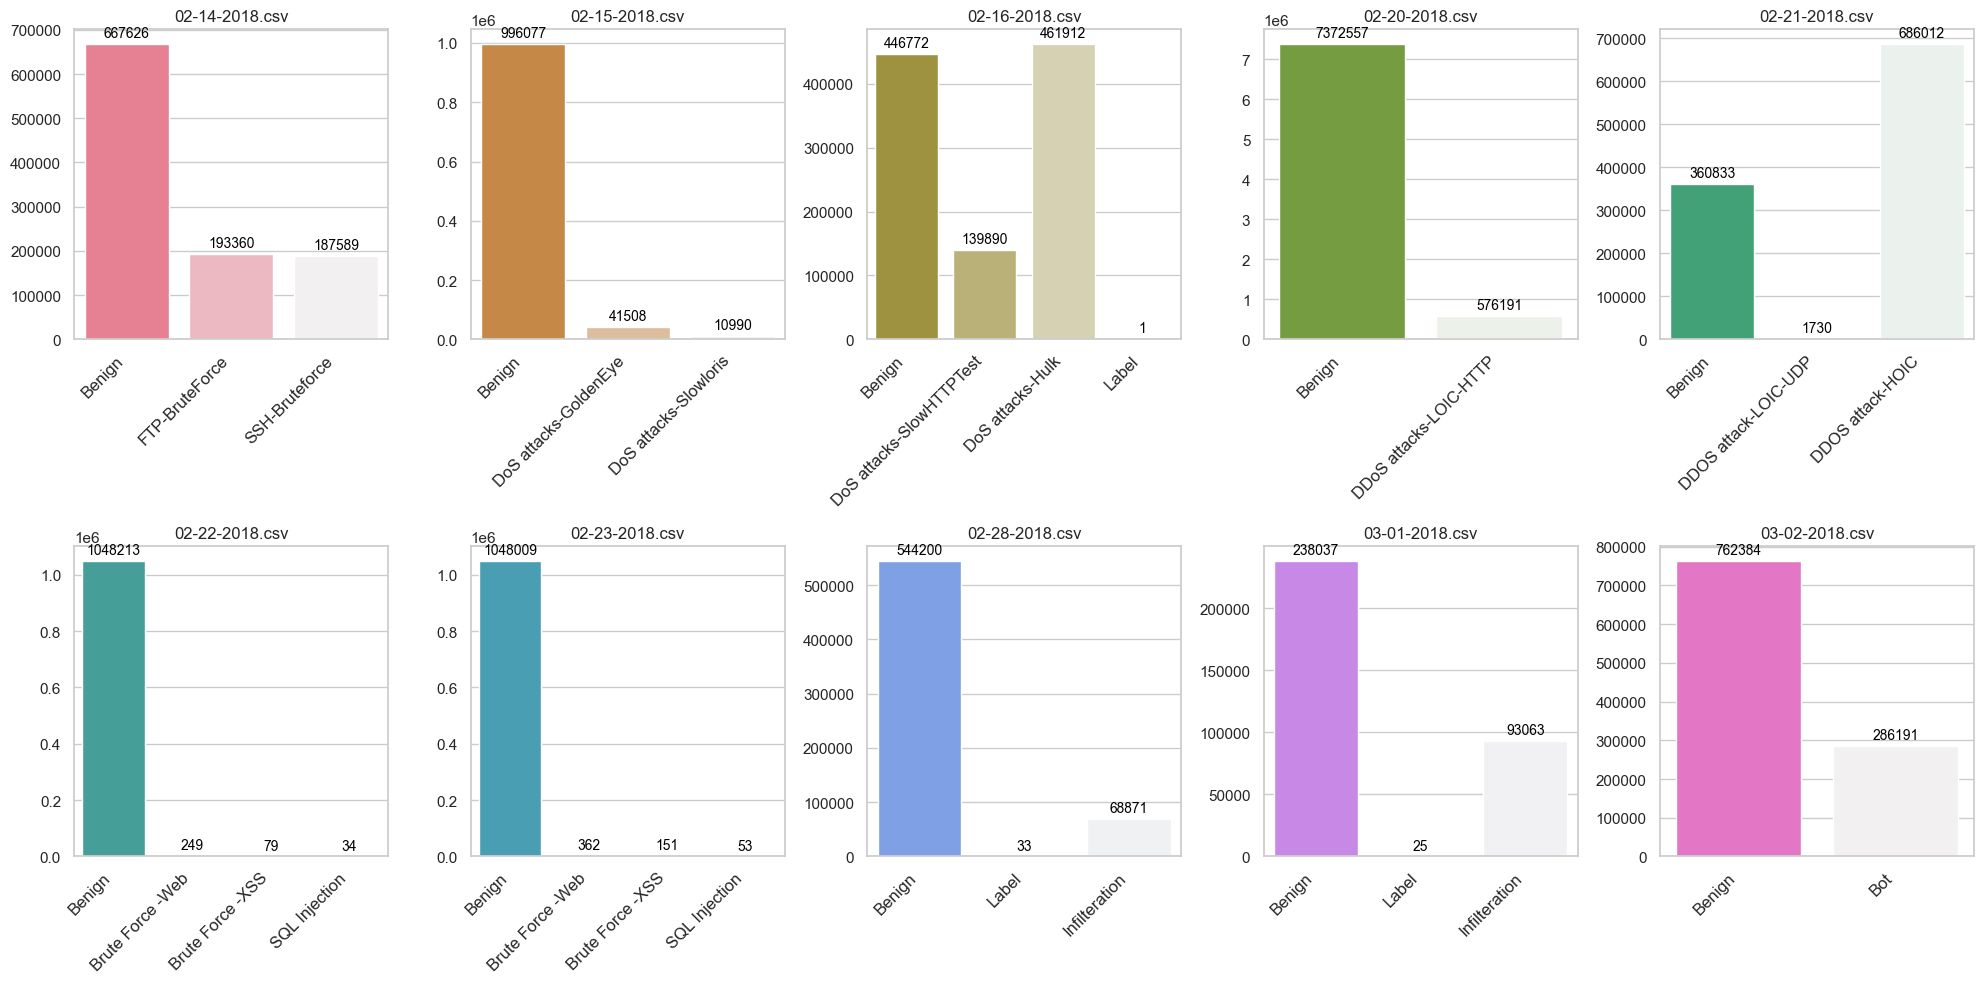

In [3]:
# 请画出每个csv 数据集标签的分布图，一个csv文件为一个簇，共10个簇，每个簇有不同的攻击类型
# 设置绘图风格
sns.set_theme(style="whitegrid")

# 创建一个调色板
palette = sns.color_palette("husl", 10)  # 10 个不同的颜色

# 创建一个大的图形
plt.figure(figsize=(20, 10))

# 绘制每个 CSV 文件的攻击类型分布
for i, (df, title) in enumerate(zip(
    [df_d1, df_d2, df_d3, df_d4, df_d5, df_d6, df_d7, df_d8, df_d9, df_d10],
    ["02-14-2018.csv", "02-15-2018.csv", "02-16-2018.csv", "02-20-2018.csv", "02-21-2018.csv",
     "02-22-2018.csv", "02-23-2018.csv", "02-28-2018.csv", "03-01-2018.csv", "03-02-2018.csv"]
)):
    plt.subplot(2, 5, i + 1)
    plt.title(title)
    ax = sns.countplot(x='Label', data=df, hue='Label', palette=sns.light_palette(palette[i], n_colors=len(df['Label'].unique()), reverse=True), legend=False)
    # plt.xlabel('attack type')
    # plt.ylabel('number of each attack type')
    
    # 在每个柱上面注明实际数量
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
    
    # 设置固定数量的刻度
    ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
    
    # 调整攻击类型字体大小和宽度
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


# Data preprocessing

In [4]:
df_d4.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)

In [5]:
## 固定列的type

def fix_data_type(df):
    
    df = df[df['Dst Port'] != 'Dst Port']
    df['Dst Port'] = df['Dst Port'].astype(int)
    df['Protocol'] = df['Protocol'].astype(int)
    df['Flow Duration'] = df['Flow Duration'].astype(int)
    df['Tot Fwd Pkts'] = df['Tot Fwd Pkts'].astype(int)
    df['Tot Bwd Pkts'] = df['Tot Bwd Pkts'].astype(int)
    df['TotLen Fwd Pkts'] = df['TotLen Fwd Pkts'].astype(int)
    df['TotLen Bwd Pkts'] = df['TotLen Bwd Pkts'].astype(int)
    df['Fwd Pkt Len Max'] = df['Fwd Pkt Len Max'].astype(int)
    df['Fwd Pkt Len Min'] = df['Fwd Pkt Len Min'].astype(int)
    df['Fwd Pkt Len Mean'] = df['Fwd Pkt Len Mean'].astype(float)
    df['Fwd Pkt Len Std'] = df['Fwd Pkt Len Std'].astype(float)
    df['Bwd Pkt Len Max'] = df['Bwd Pkt Len Max'].astype(int)
    df['Bwd Pkt Len Min'] = df['Bwd Pkt Len Min'].astype(int)
    df['Bwd Pkt Len Mean'] = df['Bwd Pkt Len Mean'].astype(float)
    df['Bwd Pkt Len Std'] = df['Bwd Pkt Len Std'].astype(float)
    df['Flow Byts/s'] = df['Flow Byts/s'].astype(float)
    df['Flow Pkts/s'] = df['Flow Pkts/s'].astype(float)
    df['Flow IAT Mean'] = df['Flow IAT Mean'].astype(float)
    df['Flow IAT Std'] = df['Flow IAT Std'].astype(float)
    df['Flow IAT Max'] = df['Flow IAT Max'].astype(int)
    df['Flow IAT Min'] = df['Flow IAT Min'].astype(int)
    df['Fwd IAT Tot'] = df['Fwd IAT Tot'].astype(int)
    df['Fwd IAT Mean'] = df['Fwd IAT Mean'].astype(float)
    df['Fwd IAT Std'] = df['Fwd IAT Std'].astype(float)
    df['Fwd IAT Max'] = df['Fwd IAT Max'].astype(int)
    df['Fwd IAT Min'] = df['Fwd IAT Min'].astype(int)
    df['Bwd IAT Tot'] = df['Bwd IAT Tot'].astype(int)
    df['Bwd IAT Mean'] = df['Bwd IAT Mean'].astype(float)
    df['Bwd IAT Std'] = df['Bwd IAT Std'].astype(float)
    df['Bwd IAT Max'] = df['Bwd IAT Max'].astype(int)
    df['Bwd IAT Min'] = df['Bwd IAT Min'].astype(int)
    df['Fwd PSH Flags'] = df['Fwd PSH Flags'].astype(int)
    df['Bwd PSH Flags'] = df['Bwd PSH Flags'].astype(int)
    df['Fwd URG Flags'] = df['Fwd URG Flags'].astype(int)
    df['Bwd URG Flags'] = df['Bwd URG Flags'].astype(int)
    df['Fwd Header Len'] = df['Fwd Header Len'].astype(int)
    df['Bwd Header Len'] = df['Bwd Header Len'].astype(int)
    df['Fwd Pkts/s'] = df['Fwd Pkts/s'].astype(float)
    df['Bwd Pkts/s'] = df['Bwd Pkts/s'].astype(float)
    df['Pkt Len Min'] = df['Pkt Len Min'].astype(int)
    df['Pkt Len Max'] = df['Pkt Len Max'].astype(int)
    df['Pkt Len Mean'] = df['Pkt Len Mean'].astype(float)
    df['Pkt Len Std'] = df['Pkt Len Std'].astype(float)
    df['Pkt Len Var'] = df['Pkt Len Var'].astype(float)
    df['FIN Flag Cnt'] = df['FIN Flag Cnt'].astype(int)
    df['SYN Flag Cnt'] = df['SYN Flag Cnt'].astype(int)
    df['RST Flag Cnt'] = df['RST Flag Cnt'].astype(int)
    df['PSH Flag Cnt'] = df['PSH Flag Cnt'].astype(int)
    df['ACK Flag Cnt'] = df['ACK Flag Cnt'].astype(int)
    df['URG Flag Cnt'] = df['URG Flag Cnt'].astype(int)
    df['CWE Flag Count'] = df['CWE Flag Count'].astype(int)
    df['ECE Flag Cnt'] = df['ECE Flag Cnt'].astype(int)
    df['Down/Up Ratio'] = df['Down/Up Ratio'].astype(int)
    df['Pkt Size Avg'] = df['Pkt Size Avg'].astype(float)
    df['Fwd Seg Size Avg'] = df['Fwd Seg Size Avg'].astype(float)
    df['Bwd Seg Size Avg'] = df['Bwd Seg Size Avg'].astype(float)
    df['Fwd Byts/b Avg'] = df['Fwd Byts/b Avg'].astype(int)
    df['Fwd Pkts/b Avg'] = df['Fwd Pkts/b Avg'].astype(int)
    df['Fwd Blk Rate Avg'] = df['Fwd Blk Rate Avg'].astype(int)
    df['Bwd Byts/b Avg'] = df['Bwd Byts/b Avg'].astype(int)
    df['Bwd Pkts/b Avg'] = df['Bwd Pkts/b Avg'].astype(int)
    df['Bwd Blk Rate Avg'] = df['Bwd Blk Rate Avg'].astype(int)
    df['Subflow Fwd Pkts'] = df['Subflow Fwd Pkts'].astype(int)
    df['Subflow Fwd Byts'] = df['Subflow Fwd Byts'].astype(int)
    df['Subflow Bwd Pkts'] = df['Subflow Bwd Pkts'].astype(int)
    df['Subflow Bwd Byts'] = df['Subflow Bwd Byts'].astype(int)
    df['Init Fwd Win Byts'] = df['Init Fwd Win Byts'].astype(int)
    df['Init Bwd Win Byts'] = df['Init Bwd Win Byts'].astype(int)
    df['Fwd Act Data Pkts'] = df['Fwd Act Data Pkts'].astype(int)
    df['Fwd Seg Size Min'] = df['Fwd Seg Size Min'].astype(int)
    df['Active Mean'] = df['Active Mean'].astype(float)
    df['Active Std'] = df['Active Std'].astype(float)
    df['Active Max'] = df['Active Max'].astype(int)
    df['Active Min'] = df['Active Min'].astype(int)
    df['Idle Mean'] = df['Idle Mean'].astype(float)
    df['Idle Std'] = df['Idle Std'].astype(float)
    df['Idle Max'] = df['Idle Max'].astype(int)
    df['Idle Min'] = df['Idle Min'].astype(int)
    
    return df

In [ ]:
df_d1 = fix_data_type(df_d1)
df_d2 = fix_data_type(df_d2)
df_d3 = fix_data_type(df_d3)
df_d4 = fix_data_type(df_d4)
df_d5 = fix_data_type(df_d5)
df_d6 = fix_data_type(df_d6)
df_d7 = fix_data_type(df_d7)
df_d8 = fix_data_type(df_d8)
df_d9 = fix_data_type(df_d9)
df_d10 = fix_data_type(df_d10)

In [7]:
def drop_infinate_null(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)
    
    return df

df_d1 = drop_infinate_null(df_d1)
df_d2 = drop_infinate_null(df_d2)
df_d3 = drop_infinate_null(df_d3)
df_d4 = drop_infinate_null(df_d4)
df_d5 = drop_infinate_null(df_d5)
df_d6 = drop_infinate_null(df_d6)
df_d7 = drop_infinate_null(df_d7)
df_d8 = drop_infinate_null(df_d8)
df_d9 = drop_infinate_null(df_d9)
df_d10 = drop_infinate_null(df_d10)

(1048575, 80)
(1044751, 80)
(1048575, 80)
(1040548, 80)
(1048574, 80)
(1048574, 80)
(7948748, 80)
(7889295, 80)
(1048575, 80)
(1048575, 80)
(1048575, 80)
(1042965, 80)
(1048575, 80)
(1042867, 80)
(613071, 80)
(606902, 80)
(331100, 80)
(328181, 80)
(1048575, 80)
(1044525, 80)


In [8]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] 
    for col in props.columns:
        if props[col].dtype != object:  

            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            else:
                props[col] = props[col].astype(np.float32)
    
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [9]:
df_d1, _ = reduce_mem_usage(df_d1)
df_d2, _ = reduce_mem_usage(df_d2)
df_d3, _ = reduce_mem_usage(df_d3)
df_d4, _ = reduce_mem_usage(df_d4)
df_d5, _ = reduce_mem_usage(df_d5)
df_d6, _ = reduce_mem_usage(df_d6)
df_d7, _ = reduce_mem_usage(df_d7)
df_d8, _ = reduce_mem_usage(df_d8)
df_d9, _ = reduce_mem_usage(df_d9)
df_d10, _ = reduce_mem_usage(df_d10)

Memory usage of properties dataframe is : 430.4241485595703  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  248.09169673919678  MB
This is  57.638888888888886 % of the initial size
Memory usage of properties dataframe is : 428.69256591796875  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  247.09363174438477  MB
This is  57.638888888888886 % of the initial size
Memory usage of properties dataframe is : 431.9991760253906  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  235.99954986572266  MB
This is  54.629629629629626 % of the initial size
Memory usage of properties dataframe is : 3250.2893829345703  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1941.1450481414795  MB
This is  59.72222222222222 % of the initial size
Memory usage of properties dataframe is : 423.99971771240234  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  238.99989414215088  MB
This is  56.3679370900581 % of the initial size
Memory usage of properties dataframe is 

In [10]:
%%time
df_all = pd.concat([df_d1, df_d2], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d1, df_d2

df_all = pd.concat([df_all, df_d3], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d3

df_all = pd.concat([df_all, df_d4], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d4

df_all = pd.concat([df_all, df_d5], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d5

df_all = pd.concat([df_all, df_d6], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d6

df_all = pd.concat([df_all, df_d7], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d7

df_all = pd.concat([df_all, df_d8], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d8

df_all = pd.concat([df_all, df_d9], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d9

df_all = pd.concat([df_all, df_d10], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d10

CPU times: total: 859 ms
Wall time: 9.84 s


In [11]:
df_all.drop(columns=['Protocol'], axis=1, inplace=True)

In [ ]:
def time2timestamp(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp'] = df['Timestamp'].values.astype(np.int64) // 10 ** 9
    return df

df_all = time2timestamp(df_all)

In [13]:
df_all.drop_duplicates(keep='first', inplace=True)

In [14]:
# print the type of columns
def print_column_type(df):
    for col in df.columns:
        print(col, df[col].dtype)


print_column_type(df_all)

Dst Port uint32
Timestamp int64
Flow Duration int64
Tot Fwd Pkts uint32
Tot Bwd Pkts uint32
TotLen Fwd Pkts uint32
TotLen Bwd Pkts uint32
Fwd Pkt Len Max uint16
Fwd Pkt Len Min uint16
Fwd Pkt Len Mean float32
Fwd Pkt Len Std float32
Bwd Pkt Len Max uint16
Bwd Pkt Len Min uint16
Bwd Pkt Len Mean float32
Bwd Pkt Len Std float32
Flow Byts/s float32
Flow Pkts/s float32
Flow IAT Mean float32
Flow IAT Std float32
Flow IAT Max int64
Flow IAT Min int64
Fwd IAT Tot int64
Fwd IAT Mean float32
Fwd IAT Std float32
Fwd IAT Max int64
Fwd IAT Min int64
Bwd IAT Tot uint32
Bwd IAT Mean float32
Bwd IAT Std float32
Bwd IAT Max uint32
Bwd IAT Min uint32
Fwd PSH Flags uint8
Bwd PSH Flags uint8
Fwd URG Flags uint8
Bwd URG Flags uint8
Fwd Header Len uint32
Bwd Header Len uint32
Fwd Pkts/s float32
Bwd Pkts/s float32
Pkt Len Min uint16
Pkt Len Max uint16
Pkt Len Mean float32
Pkt Len Std float32
Pkt Len Var float32
FIN Flag Cnt uint8
SYN Flag Cnt uint8
RST Flag Cnt uint8
PSH Flag Cnt uint8
ACK Flag Cnt uint8
UR

drop the rows that contain negative value in Fwd_Header_Length、Flow_Duration、Flow_IAT_Min columns, because it didn't make sense


In [15]:
df_all = df_all[df_all['Fwd Header Len'] >= 0]
df_all = df_all[df_all['Flow Duration'] >= 0]
df_all = df_all[df_all['Flow IAT Min'] >= 0]

drop these columns:
1. Bwd_PSH_Flags  
2. Bwd_URG_Flags  
3. Fwd_Avg_Bytes_Bulk  
4. Fwd_Avg_Packets_Bulk  
5. Fwd_Avg_Bulk_Rate  
6. Bwd_Avg_Bytes_Bulk  
7. Bwd_Avg_Packets_Bulk  
8. Bwd_Avg_Bulk_Rate   
  
Because these eight fields contained values of zero for every instance.

In [16]:
# find the columns that have the same value in all rows
def find_same_value_columns(df):
    same_value_columns = []
    for col in df.columns:
        if df[col].nunique() == 1:
            same_value_columns.append(col)
    return same_value_columns

same_value_columns = find_same_value_columns(df_all)
print(same_value_columns)

['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']


In [17]:
df_all.drop(columns=same_value_columns, axis=1, inplace=True)

drop 'Init Fwd Win Byts' and 'Init Fwd Win Byts', since about half of the total instance contained negative values for these two fields.

In [18]:
df_all.drop(columns = ['Init Fwd Win Byts', 'Init Fwd Win Byts'], axis=1, inplace=True)

drop Flow_Duration field, because some of those values were unreasonably low with zero values

In [19]:
df_all.drop(columns=['Flow Duration'], axis=1, inplace=True)

In [20]:
mapping= {'SSH-Bruteforce': 'Brute-force',
          'FTP-BruteForce': 'Brute-force',
          ################ Brute-force 
          
          'Brute Force -XSS': 'Web attack',
          'Brute Force -Web': 'Web attack',
          'SQL Injection': 'Web attack',
          ################ Web attack 
          
          'DoS attacks-Hulk': 'DoS attack',
          'DoS attacks-SlowHTTPTest': 'DoS attack',
          'DoS attacks-Slowloris': 'DoS attack',
          'DoS attacks-GoldenEye': 'DoS attack',
          ################ DoS attack 
          
          'DDOS attack-HOIC': 'DDoS attack',
          'DDOS attack-LOIC-UDP': 'DDoS attack',
          'DDoS attacks-LOIC-HTTP': 'DDoS attack',
          ################ DDoS attack 
          
          'Bot': 'Botnet',
          ################ Botnet 
          
          'Infilteration': 'Infilteration',
          ################ Infilteration 
          
          'Benign': 'Benign',
          'Label': 'Benign',
          ################ Infilteration 
    }

def transform_multi_label(df):
    print(df['Label'].value_counts())
    df['Label'] = df['Label'].map(mapping) 
    return df

delete the rows that containd NaN or Infinity values

In [21]:
transform_multi_label(df_all)

Label
Benign                      13219305
DDOS attack-HOIC              668461
DDoS attacks-LOIC-HTTP        576175
DoS attacks-Hulk              434873
Bot                           282310
Infilteration                 160604
SSH-Bruteforce                117322
DoS attacks-GoldenEye          41455
FTP-BruteForce                 39346
DoS attacks-SlowHTTPTest       19462
DoS attacks-Slowloris          10285
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 609
Brute Force -XSS                 230
SQL Injection                     87
Name: count, dtype: int64


,Dst Port,Timestamp,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,1518597061,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56320860.0,139.300034,56320958,56320761,Benign
1,0,1518597230,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56320732.0,114.551300,56320814,56320652,Benign
2,0,1518597399,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56319312.0,301.934601,56319525,56319098,Benign
3,22,1518597613,15,10,1239,2273,744,0,82.599998,196.741241,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,1518597623,14,11,1143,2209,744,0,81.642860,203.745544,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16137178,3389,1519956498,14,8,1442,1731,725,0,103.000000,191.125412,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
16137179,3389,1519956502,14,8,1440,1731,725,0,102.857140,191.172836,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
16137180,3389,1519956505,14,8,1459,1731,741,0,104.214287,195.113449,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
16137181,3389,1519956509,14,8,1459,1731,741,0,104.214287,195.113449,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [22]:
df_all['Label'].value_counts()

Label
Benign           13219305
DDoS attack       1246366
DoS attack         506075
Botnet             282310
Infilteration      160604
Brute-force        156668
Web attack            926
Name: count, dtype: int64

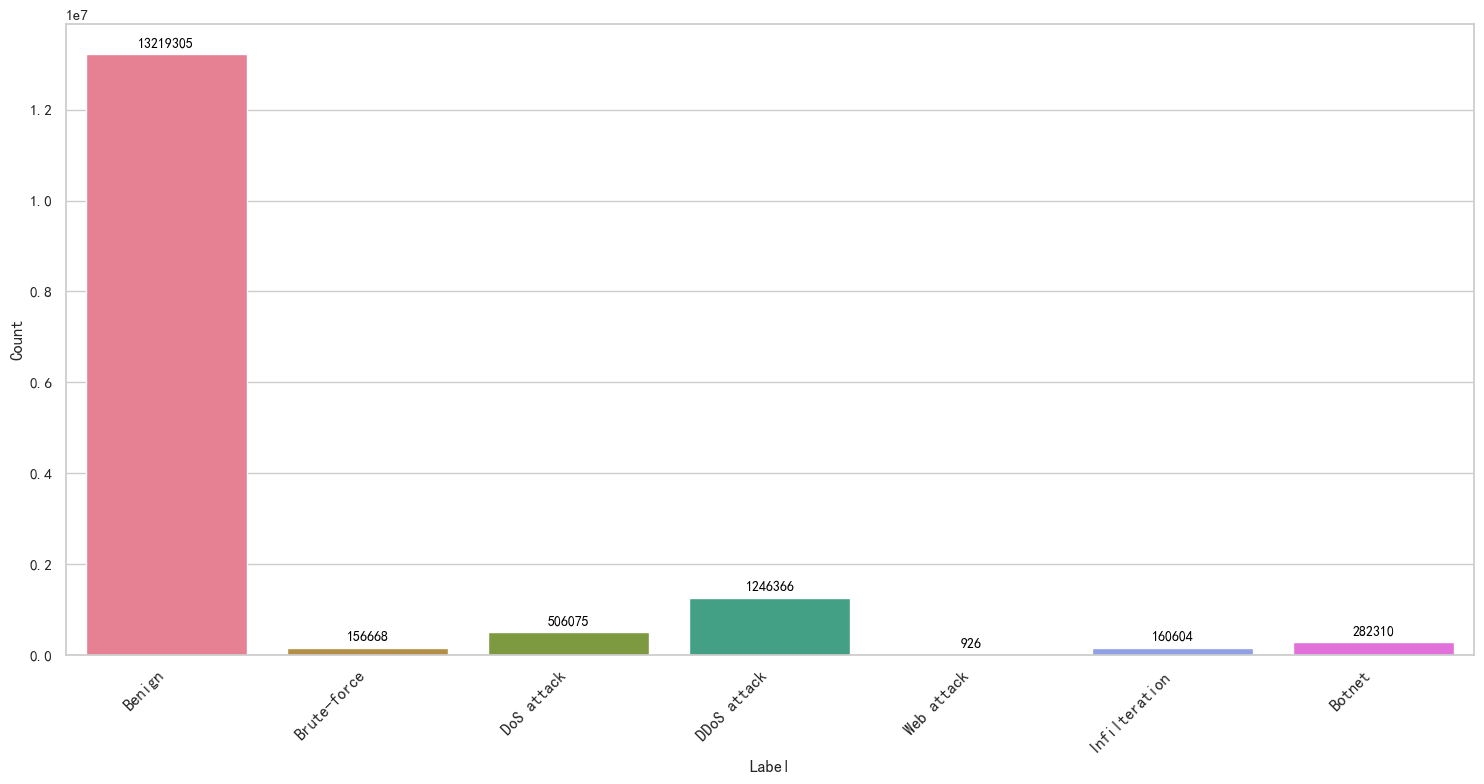

In [23]:
# 设置绘图风格
sns.set_theme(style="whitegrid")

# 创建一个调色板
palette = sns.color_palette("husl", len(df_all['Label'].unique()))  # 根据类别数量创建调色板

# 关闭任何现有的图
plt.close()

# 创建一个大的图形
plt.figure(figsize=(15, 8))

# 绘制每个类别的分布
ax = sns.countplot(data=df_all, x='Label', hue='Label', palette=palette, legend=False)

# 设置标题和标签
plt.xlabel('Label')
plt.ylabel('Count')

# 旋转 x 轴标签以便更好地显示
plt.xticks(rotation=45, ha='right', fontsize=12)

# 在每个柱上标注具体数字
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 显示图形
plt.tight_layout()
plt.show()

In [24]:
label = df_all['Label']
feature = df_all.drop(columns=['Label'], axis=1)

In [25]:
df_all.to_csv("../Data/data_all_no_balance.csv", index=False)

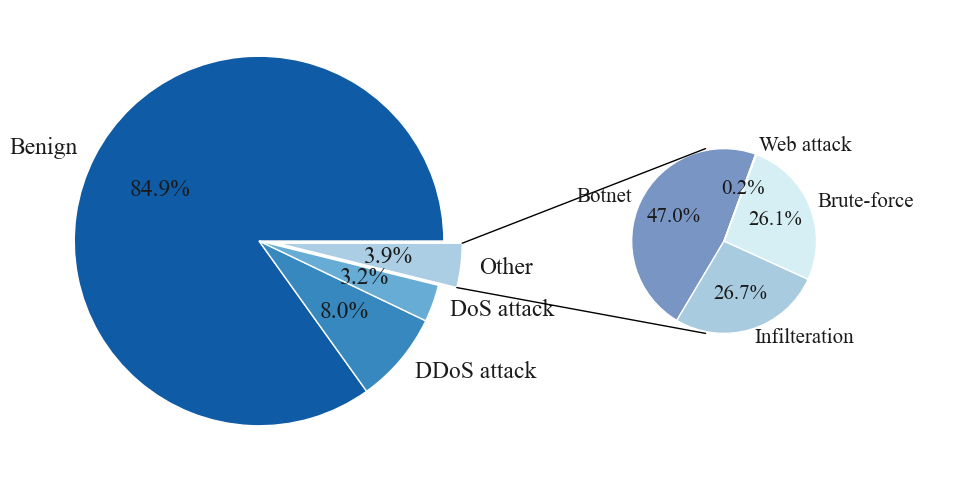

In [26]:

def huitu(data_all):
    # 使图表元素中正常显示中文
    plt.rcParams['font.sans-serif'] = 'SimHei'
    # 使坐标轴刻度标签正常显示负号
    plt.rcParams['axes.unicode_minus'] = False

    # 画布
    fig = plt.figure(figsize=(12, 6), facecolor='white')
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.subplots_adjust(wspace=0)

    # 计算每个标签的数量
    label_counts = data_all['Label'].value_counts()

    # 定义主饼图数据
    main_labels = ['Benign', 'DDoS attack', 'DoS attack', 'Other']
    other_labels = ['Botnet', 'Infilteration', 'Brute-force', 'Web attack']

    # 获取主类别的数量
    main_sizes = [
        label_counts.get('Benign', 0),
        label_counts.get('DDoS attack', 0),
        label_counts.get('DoS attack', 0),
        sum(label_counts.get(label, 0) for label in other_labels)  # 将小类别的数据合并为Other
    ]
    explode = (0, 0, 0, 0.1)  # 仅分裂出other部分

    # 主饼图
    ax1.pie(main_sizes,
            colors=['#0F5BA6', '#3688BE', '#67ACD4', '#ABCEE4'],
            explode=explode,
            autopct='%1.1f%%',
            labels=main_labels,
            textprops={'color': 'k', 'font': 'Times New Roman', 'fontsize': 17})

    # 获取小类别的数量
    other_sizes = [label_counts.get(label, 0) for label in other_labels]

    # 小饼图
    ax2.pie(other_sizes,
            colors=['#7895C4', '#A8CBDF', '#D6EFF4', '#F2FAFC'],
            autopct='%1.1f%%',
            startangle=70,
            labels=other_labels,
            radius=0.5,
            textprops={'color': 'k', 'font': 'Times New Roman', 'fontsize': 15})

    # 用 ConnectionPatch 画出两个饼图之间的连线
    ## 饼图边缘的数据
    theta1 = ax1.patches[-1].theta1
    theta2 = ax1.patches[-1].theta2
    center = ax1.patches[-1].center
    r = ax1.patches[-1].r

    width = 0.2
    # 上边缘的连线
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = np.sin(np.pi / 180 * theta2) + center[1]
    con_a = ConnectionPatch(xyA=(-width / 2, 0.5), xyB=(x, y),
                            coordsA='data', coordsB='data',
                            axesA=ax2, axesB=ax1)

    # 下边缘的连线
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = np.sin(np.pi / 180 * theta1) + center[1]
    con_b = ConnectionPatch(xyA=(-width / 2, -0.5), xyB=(x, y),
                            coordsA='data', coordsB='data',
                            axesA=ax2, axesB=ax1)

    for con in [con_a, con_b]:
        con.set_linewidth(1)  # 连线宽度
        con.set_color([0, 0, 0])  # 连线颜色
        ax2.add_artist(con)  # 添加连线

    fig.savefig('Figure.pdf')
    plt.show()

huitu(df_all)

# Feature selection

In [39]:
feature_points = {}
columns = list(feature.columns)

In [28]:
# Information Gain
mutual_info = mutual_info_classif(feature, label)
scaler = MinMaxScaler()
mutual_info = scaler.fit_transform(mutual_info.reshape(-1, 1)).reshape(-1)
for i in range(len(columns)):
    if columns[i] not in feature_points:
        feature_points[columns[i]] = 0  # 初始化为 0
    feature_points[columns[i]] += mutual_info[i]

In [41]:
# Chi-Squarded
scaler = MinMaxScaler()
feature_scaled = scaler.fit_transform(feature)
chi_selector = SelectKBest(chi2, k=60)
X_new = chi_selector.fit_transform(feature_scaled, label)
score = chi_selector.scores_
scaler = MinMaxScaler()
score = scaler.fit_transform(score.reshape(-1, 1)).reshape(-1)

for i in range(len(columns)):
    if columns[i] not in feature_points:
        feature_points[columns[i]] = 0
    feature_points[columns[i]] += score[i]

In [42]:
# Random Forest
rf = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5, n_jobs=-1)

rf.fit(feature, label)

importances = rf.feature_importances_
scaler = MinMaxScaler()
importances = scaler.fit_transform(importances.reshape(-1, 1)).reshape(-1)
for i in range(len(columns)):
    if columns[i] not in feature_points:
        feature_points[columns[i]] = 0
    feature_points[columns[i]] += importances[i]

In [ ]:
# CatBoost
catb = CatBoostClassifier(learning_rate=0.01, iterations=200, depth=10, thread_count=-1)

catb.fit(feature, label)
importances = catb.feature_importances_
scaler = MinMaxScaler()
importances = scaler.fit_transform(importances.reshape(-1, 1)).reshape(-1)

for i in range(len(columns)):
    if columns[i] not in feature_points:
        feature_points[columns[i]] = 0
    feature_points[columns[i]] += importances[i]

In [ ]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.01)

lgb_model.fit(feature, label)
importances = lgb_model.feature_importances_

scaler = MinMaxScaler()
importances = scaler.fit_transform(importances.reshape(-1, 1)).reshape(-1)

for i in range(len(columns)):
    if columns[i] not in feature_points:
        feature_points[columns[i]] = 0
    feature_points[columns[i]] += importances[i]

In [45]:
feature_points = dict(sorted(feature_points.items(), key=lambda x: x[1], reverse=True))

In [ ]:
data_20 = df_all[list(feature_points.keys())[:20]]
data_20['Label'] = df_all['Label']
data_20.to_csv("../Data/data_20_features.csv", index=False)

data_30 = df_all[list(feature_points.keys())[:30]]
data_30['Label'] = df_all['Label']
data_30.to_csv("../Data/data_30_features.csv", index=False)

data_40 = df_all[list(feature_points.keys())[:40]]
data_40['Label'] = df_all['Label']
data_40.to_csv("../Data/data_40_features.csv", index=False)

data_50 = df_all[list(feature_points.keys())[:50]]
data_50['Label'] = df_all['Label']
data_50.to_csv("../Data/data_50_features.csv", index=False)
data_60 = df_all[list(feature_points.keys())[:60]]
data_60['Label'] = df_all['Label']
data_60.to_csv("../Data/data_60_features.csv", index=False)

df_all = pd.read_csv("../Data/data_all_features.csv")

In [11]:
def minmaxscaler(df):
    scaler = MinMaxScaler()
    feature = df.drop(columns=['Label'], axis=1)
    label = df['Label']

    feature_scaled = scaler.fit_transform(feature)

    df_scaled = pd.DataFrame(feature_scaled, columns=feature.columns)
    df_scaled['Label'] = label.values

    return df_scaled

In [12]:
data_20_scaled = minmaxscaler(data_20)
del data_20

data_30_scaled = minmaxscaler(data_30)
del data_30

data_40_scaled = minmaxscaler(data_40)
del data_40

data_50_scaled = minmaxscaler(data_50)
del data_50

data_60_scaled = minmaxscaler(data_60)
del data_60

data_all_scaled = minmaxscaler(df_all)
del df_all

In [15]:
data_20_scaled.to_csv("../Data/data_20_features_scaled.csv", index=False)
data_30_scaled.to_csv("../Data/data_30_features_scaled.csv", index=False)
data_40_scaled.to_csv("../Data/data_40_features_scaled.csv", index=False)
data_50_scaled.to_csv("../Data/data_50_features_scaled.csv", index=False)
data_60_scaled.to_csv("../Data/data_60_features_scaled.csv", index=False)
data_all_scaled.to_csv("../Data/data_all_features_scaled.csv", index=False)

In [16]:
# split data to train and test
def split_data(df):
    feature = df.drop(columns=['Label'], axis=1)
    label = df['Label']

    X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

X_train_20, X_test_20, y_train_20, y_test_20 = split_data(data_20_scaled)
X_train_30, X_test_30, y_train_30, y_test_30 = split_data(data_30_scaled)
X_train_40, X_test_40, y_train_40, y_test_40 = split_data(data_40_scaled)
X_train_50, X_test_50, y_train_50, y_test_50 = split_data(data_50_scaled)
X_train_60, X_test_60, y_train_60, y_test_60 = split_data(data_60_scaled)
X_train_all, X_test_all, y_train_all, y_test_all = split_data(data_all_scaled)

# 类别不平衡解决

## RandomUnderSampler + SMOTE

In [23]:
def sample_data(feature, label):
    rus = RandomUnderSampler(sampling_strategy={"Benign" : 5000000}, random_state=42)
    feature_resampled, label_resampled = rus.fit_resample(feature, label)
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    feature_resampled, label_resampled = smote.fit_resample(feature_resampled, label_resampled)
    feature_resampled = feature_resampled.astype(np.float32)

    data_resampled = pd.concat([feature_resampled, label_resampled], axis=1)
    return data_resampled


In [ ]:
train_20_resampled = sample_data(X_train_20, y_train_20)
train_20_resampled.to_csv("../Data/train_20_features_scaled_resampled.csv", index=False)
# del train_20_resampled

train_30_resampled = sample_data(X_train_30, y_train_30)
train_30_resampled.to_csv("../Data/train_30_features_scaled_resampled.csv", index=False)
del train_30_resampled

train_40_resampled = sample_data(X_train_40, y_train_40)
train_40_resampled.to_csv("../Data/train_40_features_scaled_resampled.csv", index=False)
del train_40_resampled

train_50_resampled = sample_data(X_train_50, y_train_50)
train_50_resampled.to_csv("../Data/train_50_features_scaled_resampled.csv", index=False)
del train_50_resampled

train_60_resampled = sample_data(X_train_60, y_train_60)
train_60_resampled.to_csv("../Data/train_60_features_scaled_resampled.csv", index=False)
del train_60_resampled

train_all_resampled = sample_data(X_train_all, y_train_all)
train_all_resampled.to_csv("../Data/train_all_features_scaled_resampled.csv", index=False)
del train_all_resampled

test_20 = pd.concat([X_test_20, y_test_20], axis=1)
test_20.to_csv("../Data/test_20_features_scaled.csv", index=False)
# del test_20

test_30 = pd.concat([X_test_30, y_test_30], axis=1)
test_30.to_csv("../Data/test_30_features_scaled.csv", index=False)
del test_30

test_40 = pd.concat([X_test_40, y_test_40], axis=1)
test_40.to_csv("../Data/test_40_features_scaled.csv", index=False)
del test_40

test_50 = pd.concat([X_test_50, y_test_50], axis=1)
test_50.to_csv("../Data/test_50_features_scaled.csv", index=False)
del test_50

test_60 = pd.concat([X_test_60, y_test_60], axis=1)
test_60.to_csv("../Data/test_60_features_scaled.csv", index=False)
del test_60

test_all = pd.concat([X_test_all, y_test_all], axis=1)
test_all.to_csv("../Data/test_all_features_scaled.csv", index=False)
del test_all

In [ ]:
def classify_label(label):
    return 'Benign' if label == 'Benign' else 'Malicious'

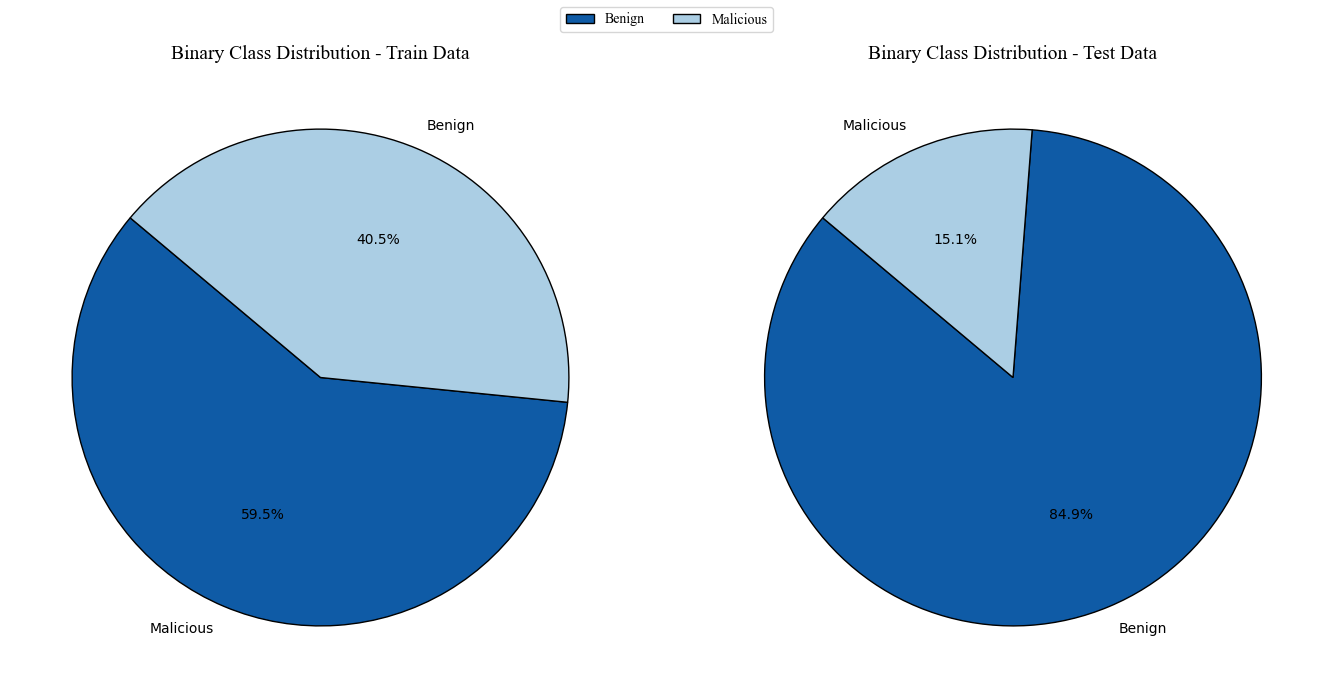

In [17]:
train_20_resampled['Class'] = train_20_resampled['label'].apply(classify_label)
test_20['Class'] = test_20['label'].apply(classify_label)

train_class_distribution = train_20_resampled['Class'].value_counts()
test_class_distribution = test_20['Class'].value_counts()

custom_colors = ['#0F5BA6', '#ABCEE4']

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(train_class_distribution, labels=train_class_distribution.index, autopct='%1.1f%%', startangle=140,
            colors=custom_colors, wedgeprops=dict(edgecolor='k'))
axes[0].set_title('Binary Class Distribution - Train Data', fontsize=14, fontweight='normal', fontname='Times New Roman')

axes[1].pie(test_class_distribution, labels=test_class_distribution.index, autopct='%1.1f%%', startangle=140,
            colors=custom_colors, wedgeprops=dict(edgecolor='k'))
axes[1].set_title('Binary Class Distribution - Test Data', fontsize=14, fontweight='normal', fontname='Times New Roman')

# fig.suptitle('Binary Class Distribution in Training and Testing datasets', fontsize=16, fontweight='normal', fontname='Times New Roman')

fig.legend(labels=['Benign', 'Malicious'], loc='upper center', ncol=2, fontsize=12, frameon=True, prop={'family': 'Times New Roman'})

plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()
